# 2016-09-21: Introduction to scikit-learn
This tutorial is based on resources from http://scikit-learn.org and the scikit-learn tutorial at Scipy 2013 by Gael Varoquaux, Jake VanderPlas and Olivier Grisel (https://www.youtube.com/watch?v=r4bRUvvlaBw and https://github.com/jakevdp/sklearn_scipy2013).

Machine learning is about creating models from data: for that reason, we’ll start by discussing how data can be represented in order to be understood by the computer. Along with this, we’ll build on our matplotlib examples from the previous lab and show some examples of how to visualize data.

Most machine learning algorithms implemented in scikit-learn expect data to be stored in a two-dimensional array, of shape `(n_samples, n_features)`. The arrays can be either NumPy arrays, or in some cases `scipy.sparse` matrices. The number of features must be fixed in advance. However it can be very high dimensional (e.g. millions of features) with most of them being zeros for a given sample. This is a case where `scipy.sparse` matrices can be useful, in that they are much more memory-efficient than NumPy arrays.

## 1. The endometrium vs uterus cancer data

For this lab and many of the coming ones, we will work with gene expression data measured on endometrium and ovary tumors. The data originally comes from http://gemler.fzv.uni-mb.si/index.php but has been downsized so that it is easier to work with in our labs.

The data we will work with contains the expression of 3,000 genes, measured for 61 endometrium tumors and 123 uterus tumors.

### Loading the data
The data is stored in a CSV file, `small_Endometrium_Uterus.csv`. Many utilities can be used to read CSV files, including the `csv` module and the `pandas` module (that is meant for data mining). We will focus on using numpy directly.

A quick look at the file shows us that
* its first line is a header
* each of its lines is a tumor sample. 
* the first column of each line is the tumor sample's ID
* the last column of each line is the type of tissue (Endometrium or Uterus)
* all columns in between give the expression of one gene.

In [1]:
import numpy as np

In [2]:
# Load the gene expression data
X = np.loadtxt('data/small_Endometrium_Uterus.csv',  delimiter=',', 
               skiprows=1, usecols=range(1, 3001))

In [83]:
Z = np.loadtxt('data/small_Endometrium_Uterus.csv',  delimiter=',', 
               skiprows=1, usecols=range(1, 3002))
Z[:,2999]

ValueError: could not convert string to float: b'Endometrium'

In [9]:
# Load the labels
y = np.loadtxt('data/small_Endometrium_Uterus.csv', delimiter=',', 
               skiprows=1, usecols=[3001], dtype='bytes').astype('str')

# Convert 'Endometrium' to 0 and 'Uterus' to 1
y = np.where(y=='Endometrium', 0, 1)
print(y)

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]


In [6]:
# We could have done the previous operation in one step, using a converter
y = np.loadtxt('data/small_Endometrium_Uterus.csv', delimiter=',', skiprows=1, usecols=[3001], 
               converters={3001: lambda s: 0 if s=='Endometrium' else 1}, dtype='int')
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Visualizing the data

In [7]:
# Load pylab
%pylab inline

Populating the interactive namespace from numpy and matplotlib


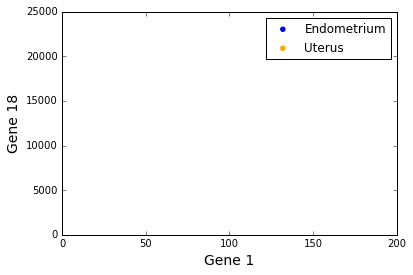

In [19]:
# Visualize the data across 2 of its axes
idx_1 = 1 # first axis (or gene)
idx_2 = 18 # second axis (or gene)
plt.scatter(X[y==0, idx_1], X[y==0, idx_2], # y==0 gives the indices of the columns for which y is equal to 0
            color='blue', label='Endometrium')
plt.scatter(X[y==1, idx_1], X[y==1, idx_2], color='orange', label='Uterus')
plt.legend(scatterpoints=1)
plt.xlim(0,200)
plt.ylim(0,25000)
plt.xlabel('Gene %d' % idx_1, fontsize=14)
plt.ylabel('Gene %d' % idx_2, fontsize=14)

Play with the values of `idx_1` and `idx_2`. What do you notice about the range of the values taken by the different genes?

## 2. Gaussian Naive Bayes

Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html 

Our goal here is to try to classify points between endometrium and uterus tumors.

In [60]:
# import Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

In [61]:
# create a Gaussian Naive Bayes classifier i.e. an instance of GaussianNB
gnb = GaussianNB()

In [68]:
# fit the classifier to the data
gnb.fit(X, y)
gnb.class_prior_

array([ 0.33333333,  0.66666667])

In [53]:
# predict on the same data
y_pred = gnb.predict(X)

In [24]:
# compute the number of mislabeled genes
print("Number of mislabeled points out of a total %d points : %d" % \
      (X.shape[0], (y != y_pred).sum()))

Number of mislabeled points out of a total 183 points : 21


In [27]:
# Score the model
from sklearn import metrics
print("Accuracy: %.3f" % metrics.accuracy_score(y, y_pred))

Accuracy: 0.885


### ROC Curve

Building an ROC curve requires to use the probability estimates for the test data points *before* they are thresholded.

In [45]:
# Get probability estimates
y_prob = gnb.predict_proba(X)
print(y_prob.shape)
y_prob

(183, 2)


array([[  1.00000000e+000,   2.84024282e-014],
       [  1.00000000e+000,   8.36056083e-033],
       [  1.00000000e+000,   2.16180037e-027],
       [  1.00000000e+000,   9.22590124e-019],
       [  1.00000000e+000,   3.39266390e-024],
       [  1.00000000e+000,   6.96222735e-293],
       [  1.00000000e+000,   0.00000000e+000],
       [  1.00583540e-279,   1.00000000e+000],
       [  2.04403605e-206,   1.00000000e+000],
       [  0.00000000e+000,   1.00000000e+000],
       [  3.17278306e-143,   1.00000000e+000],
       [  0.00000000e+000,   1.00000000e+000],
       [  0.00000000e+000,   1.00000000e+000],
       [  7.27208053e-123,   1.00000000e+000],
       [  1.84395534e-086,   1.00000000e+000],
       [  0.00000000e+000,   1.00000000e+000],
       [  1.57061270e-156,   1.00000000e+000],
       [  2.43052574e-067,   1.00000000e+000],
       [  0.00000000e+000,   1.00000000e+000],
       [  1.00000000e+000,   0.00000000e+000],
       [  1.00000000e+000,   6.05967513e-103],
       [  1.0

**Question:** `y_prob` returns two values for each data point because it returns one probability estimate per class for each data point. The order in which the classes appear are given by `gnb.classes_`. How do you get the 1-dimensional array that only contains the estimated probability for each point to belong to the positive class?  

In [46]:
y_prob[:,1]

array([  2.84024282e-014,   8.36056083e-033,   2.16180037e-027,
         9.22590124e-019,   3.39266390e-024,   6.96222735e-293,
         0.00000000e+000,   1.00000000e+000,   1.00000000e+000,
         1.00000000e+000,   1.00000000e+000,   1.00000000e+000,
         1.00000000e+000,   1.00000000e+000,   1.00000000e+000,
         1.00000000e+000,   1.00000000e+000,   1.00000000e+000,
         1.00000000e+000,   0.00000000e+000,   6.05967513e-103,
         2.16270358e-203,   5.17774978e-102,   1.95130116e-077,
         1.00000000e+000,   1.00000000e+000,   1.00000000e+000,
         1.00000000e+000,   4.52903823e-002,   1.55361297e-091,
         1.00000000e+000,   1.00000000e+000,   7.87682870e-151,
         1.00000000e+000,   1.00000000e+000,   1.00000000e+000,
         1.00000000e+000,   1.00000000e+000,   4.23459483e-194,
         0.00000000e+000,   3.59773765e-047,   1.07713652e-100,
         1.08559178e-121,   0.00000000e+000,   3.33430031e-059,
         1.00000000e+000,   1.00000000e+

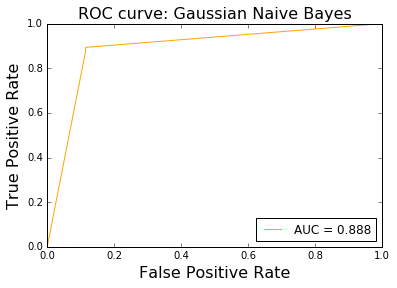

In [47]:
# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y, y_prob[:, 1], pos_label=1)

# Area under the ROC curve
auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, '-', color='orange', label='AUC = %0.3f' % auc)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Gaussian Naive Bayes', fontsize=16)
plt.legend(loc="lower right")

**Question:** What are the parameters of the model we have trained? How many of them are they? How can you access them?

In [70]:
gnb.theta_

array([[   26.61803279,  9199.51803279,    44.3147541 , ...,
          121.8295082 ,   121.94590164,    36.21639344],
       [   31.42131148,  9042.91803279,    57.90327869, ...,
          151.3704918 ,   134.03278689,    35.65      ]])

In [72]:
gnb.sigma_

array([[  6.11284988e+02,   2.10112675e+07,   2.54271395e+03, ...,
          9.53875346e+03,   2.71018529e+04,   1.32044226e+03],
       [  1.30276519e+03,   2.19631790e+07,   1.61332248e+04, ...,
          1.15641399e+04,   4.80117057e+04,   1.34616912e+03]])

**Question:** What is it problematic to have evaluated our classifier on the training data? 

Même échantillon de test et d'entrainement. On ne sait pas comment va se comporter l'algorithme sur des données nouvelles...

## 3. Cross-validation

In [73]:
# Set up a stratified 10-fold cross-validation
from sklearn import cross_validation
folds = cross_validation.StratifiedKFold(X, 10, shuffle=True)

In [86]:
# This is one way to access the training and test points
for ix, (tr, te) in enumerate(folds):
    print(tr)
    print("Fold %d" % ix)
    print("\t %d training points" % len(tr))
    print("\t %d test points" % len(te))

[  2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  19  20  21
  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  50  51  52  53  54  55  56  58  59  60
  61  62  64  66  67  68  69  70  71  72  73  74  75  77  78  79  81  82
  83  84  86  87  88  89  90  91  92  93  94  95  97  98  99 101 103 104
 105 106 108 109 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 149 150 151 152 153 154 155 156 157 158 160 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182]
Fold 0
	 163 training points
	 20 test points
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36
  37  40  41  43  44  45  46  49  50  51  52  54  55  56  57  58  59  61
  62  63  65  66  68  72  73  74  75  76  77  78  79  80  81  82  83  84

**Question:** Create a loop that goes through all 10 folds and for each fold:
* trains a Gaussian Naive Bayes model on the training data
* uses this model to make predictions on the test data. 
In this fashion you should be able to form *a single vector of predictions* `y_prob_cv` (as each point from the data appears once as a test point in the cross-validation).

In [88]:
for ix, (tr, te) in enumerate(folds):
    gnb = GaussianNB()
    gnb.fit(X[tr],y[tr])
    y_pred_cv = gnb.predict(X)
    print("Number of mislabeled points out of a total %d points : %d" % \
      (X[tr].shape[0], (y != y_pred_cv).sum()))

Number of mislabeled points out of a total 163 points : 23
Number of mislabeled points out of a total 164 points : 26
Number of mislabeled points out of a total 165 points : 24
Number of mislabeled points out of a total 165 points : 22
Number of mislabeled points out of a total 165 points : 21
Number of mislabeled points out of a total 165 points : 24
Number of mislabeled points out of a total 165 points : 20
Number of mislabeled points out of a total 165 points : 24
Number of mislabeled points out of a total 165 points : 25
Number of mislabeled points out of a total 165 points : 25


**Question:** Evaluate the performance of your model (accuracy, AUC, ROC-AUC). How does it compare to the one you previously obtained?

**Question:** The `sklearn.cross_validation` module provides some utilities to make cross-validated predictions. Compare the results you obtained to what they return.

In [ ]:
gnb = GaussianNB()
cv_aucs = cross_validation.cross_val_score(gnb, X, y, cv=folds, scoring='roc_auc')
print np.mean(cv_aucs)

# Note that averaging the AUCs obtained over 10 folds is not exactly the same as 
# globally computing the AUC for the predictions made within the cross-validation loop.

In [ ]:
gnb = GaussianNB()
print "Cross-validated accuracy: %.3f" % \
    metrics.accuracy_score(y, cross_validation.cross_val_predict(gnb, X, y, cv=folds))
# This should return the same as 
print "Cross-validated accuracy: %.3f" % metrics.accuracy_score(y, np.where(y_prob_cv > 0.5, 1, 0))    

## 4. Iris data
As an example of a simple dataset, we’re going to take a look at the Iris data stored by scikit-learn. The data is a classical UCI dataset and consists of measurements of three different species of irises.

You can learn more about this data set here: https://en.wikipedia.org/wiki/Iris_flower_data_set.

**Question:** What features could you use to represent irises in order to decide to which of the three species they belong?

scikit-learn has a very straightforward set of data on these iris species. The data consist of the following:
* Features in the Iris dataset:
    * sepal length in cm
    * sepal width in cm
    * petal length in cm
    * petal width in cm
* Target classes to predict:
    * Iris setosa
    * Iris versicolour
    * Iris virginica

### Loading the data

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()

In [ ]:
# iris is a Bunch object
# see what’s available in iris:
iris.keys()

In [ ]:
# The features of each sample flower are stored in the data
# attribute of the dataset:
n_samples, n_features = iris.data.shape
print n_samples
print n_features
print iris.data[0]

In [ ]:
# The information about the class of each sample is stored in the target
# attribute of the dataset:
print iris.target.shape
print iris.target

In [ ]:
# The names of the classes are stored in the last attribute,
# namely target_names:
print iris.target_names

### Visualizing the data

In [ ]:
# This data is four dimensional, but we can visualize two of the dimensions at a time using a simple scatter-plot.
%pylab inline
idx_1 = 0 # index of the first feature to plot
idx_2 = 1 # index of the second feature to plot

# Scatterplot
plt.scatter(iris.data[:, idx_1], iris.data[:, idx_2], s=40, c=iris.target)

# Create a formatter that will label the colorbar with the correct target names.
# lambda i, *args: iris.target_names[int(i)] converts an index i into the corresponding label
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.colorbar(ticks=[0, 1, 2], format=formatter)

plt.xlabel(iris.feature_names[idx_1], fontsize=14)
plt.ylabel(iris.feature_names[idx_2], fontsize=14)

**Question:** Change `idx_1` and `idx_2`, and find (visually) which combination of two parameters best separates the three classes.

**Question:** Create a Gaussian Naive Bayes classifier and train it on the Iris data, using only the two features you have identified in the previous question. How many instances are misclassified?

## 5. Digits data

Let us now take a look at the Digits dataset. This data set, also very classical, contains images of hand-written digits, each labeled with the corresponding digit. This means there are 10 classes in this data. Each image has been compressed into an 8 × 8 matrix.

### Loading the digits data

In [ ]:
# Load the digits dataset
from sklearn.datasets import load_digits
digits = load_digits()

In [ ]:
# Each data point is an image, and has for target the number it represents
print np.unique(digits.target)

What is the difference between `digits.data` and `digits.images`? Actually, `digits.data` is simply `digits.images` reshaped, with the 8×8 array flattened out in a 64-dimensional vector. These two representations can exist without needing to fully duplicate the data, and hence the memory overhead is very small. Indeed, the two arrays, although they have different shapes, point at the same memory block. To check this is true:

In [ ]:
# check the two arrays contain identical data
print np.all(digits.images.reshape((1797, 64)) == digits.data)

# check the two arrays point to the same memory address
print digits.data.__array_interface__['data']
print digits.images.__array_interface__['data']

### Visualizing the digits data

In [ ]:
# set up a figure that will contain multiple subplots
fig = plt.figure(figsize=(6, 6)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the 49 first digits: each image is 8 by 8 pixels
for i in range(49):
    ax = fig.add_subplot(7, 7, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.Greys, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 6, str(digits.target[i]))
plt.show()    

**Question:** What is the effect of the `interpolation='nearest'` parameter?

**Question:** Modify the above script to visualize all the “8” contained in the data. Use the `cmap` option of `imshow` to display the data with a colormap that is more appropriate for visualizing intensities.

**Question:** Create a Gaussian Naive Bayes classifier and train it on the Digits data. Look at some of the mislabeled digits. What were their actual class, what digit were they mistaken for? Can you guess why?